### Data

In [1]:
library("boot")
data("urine")
?urine
dim(urine)
head(urine)

Warning message:
"package 'boot' was built under R version 3.4.4"

[1] 79  7

r,gravity,ph,osmo,cond,urea,calc
0,1.021,4.91,725,NA,443,2.45
0,1.017,5.74,577,20.0,296,4.49
0,1.008,7.20,321,14.9,101,2.36
0,1.011,5.51,408,12.6,224,2.15
0,1.005,6.52,187,7.5,91,1.16
0,1.020,5.27,668,25.3,252,3.34


In [2]:
# Dataset has some missing values. For now let's drop those records.

data = na.omit(urine)
dim(data)

[1] 77  7

In [106]:
library("corrplot")
CORR = function(data){
    Cor = cor(data)
    corrplot(Cor, type="upper", method="ellipse", tl.pos="d")
    corrplot(Cor, type="lower", method="number", col="black", 
             add=TRUE, diag=FALSE, tl.pos="n", cl.pos="n")
}

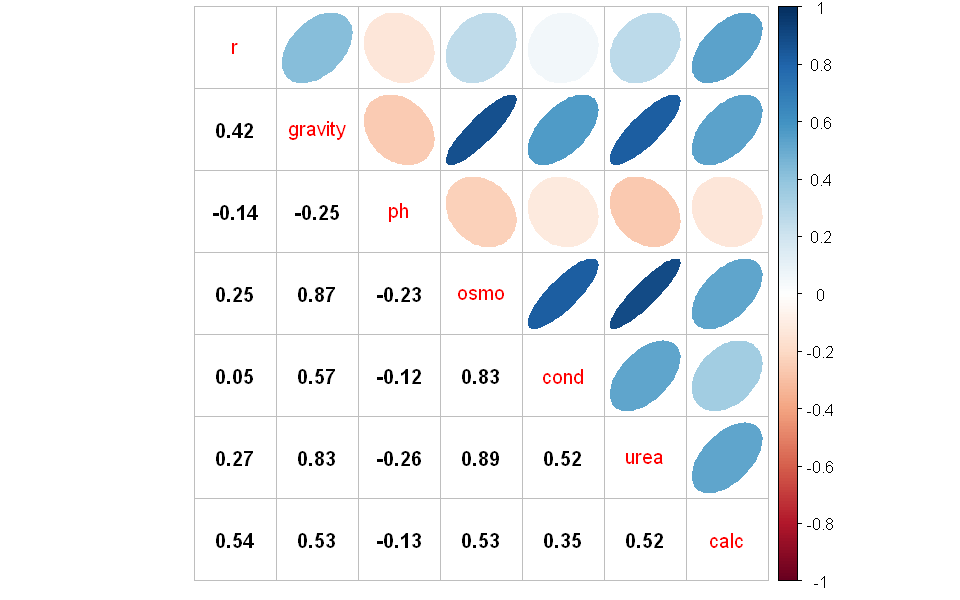

In [107]:
CORR(data)

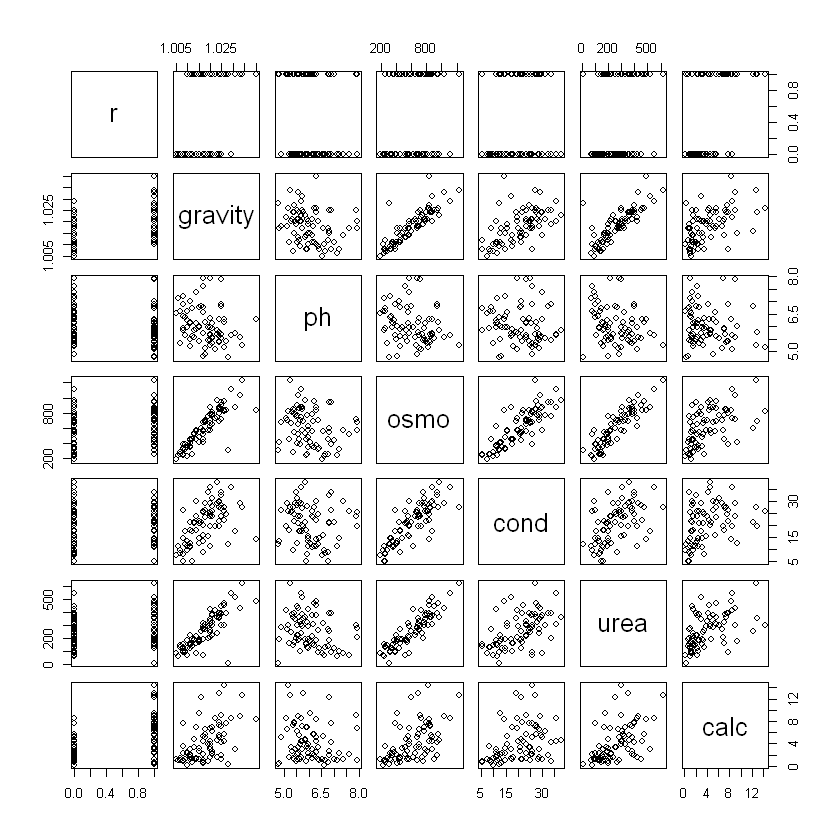

In [4]:
pairs(data)

Collinearity between x variables or explanatory variables in linear regression models can cause trouble for statistical inference. Two correlated variables will compete for the ability to predict the response variable, leading to unstable estimation. This is not a problem for prediction of the response. So, if prediction is our only goal of the analysis, then it's not a problem. But, if our objective is to discover how the variables relate to the response, we should avoid collinearity.

In [5]:
# Now we have to do variable selection here because there is strong corelation between few variables like  specific gravity
# any osmosity. One way to do this is to fit seprate model with these varaibles and choose model with best deviance inforamtion
# criteria value. Another way is to use a linear model where priors for the linear cofficients favours values near zero. Values
# near zero represents weak relationships. This way, burden of establishing an association between the varaibles lies withing 
# the data. If there is no strong signal, we assume it doesn't exist because priors favours the scenario.

In [6]:
# Design matrix. Do standard scaling here.

X = scale(data[,-1], center = TRUE, scale = TRUE)
head(X)

,gravity,ph,osmo,cond,urea,calc
2,-0.1403037,-0.4163725,-0.1528785,-0.1130908,0.25747827,0.09997564
3,-1.3710690,1.6055972,-1.2218894,-0.7502609,-1.23693077,-0.54608444
4,-0.9608139,-0.7349020,-0.8585927,-1.0376121,-0.29430353,-0.60978050
5,-1.7813240,0.6638579,-1.7814497,-1.6747822,-1.31356713,-0.91006194
6,0.2699514,-1.0672806,0.2271214,0.5490664,-0.07972172,-0.24883614
7,-0.8240622,-0.5825618,-0.6372741,-0.4379226,-0.51654898,-0.83726644


In [7]:
# As data is scaled on standard scale, the mean of each column will be zero or close to zero and standard deviation equals 1.

colMeans(X)
apply(X, 2, sd) # 2 is used to represent axis.

gravity            ph          osmo          cond          urea 
-9.861143e-15  8.511409e-17  1.515743e-16 -1.829852e-16  7.335402e-17 
         calc 
-1.689666e-18

gravity      ph    osmo    cond    urea    calc 
      1       1       1       1       1       1

<h1><center>Model 1 </center></h1>

### Modellling

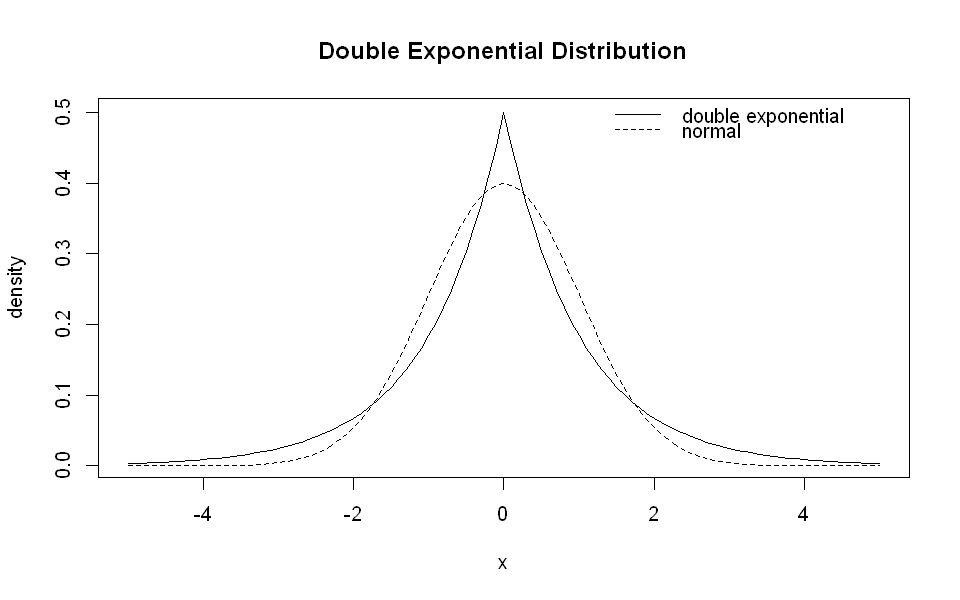

In [8]:
# The prior which I'm going to use is double exponential prior or Laplacian Prior. It favous values near zero.

ddexp = function(x, mu, tau){
    0.5*tau*exp(-tau*abs(x-mu))
}

rdexp = function(n, mu, tau){
    x = rnorm(n, 0.0, tau/sqrt(2))
    0.5*tau*exp(-tau*abs(x-mu))
}

options(repr.plot.width=8, repr.plot.height=5)

curve(ddexp(x, mu=0, tau=1.0), from=-5.0, to=5.0, ylab="density", main="Double Exponential Distribution")
curve(dnorm(x, mean=0, sd=1.0), from=-5.0, to=5.0, lty=2, add=TRUE)
legend("topright", legend = c("double exponential", "normal"), lty=c(1, 2), bty="n")

In [9]:
library("coda")
library("rjags")

Warning message:
"package 'coda' was built under R version 3.4.4"Warning message:
"package 'rjags' was built under R version 3.4.4"Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


In [10]:
set.seed(92)

In [11]:
mod_1_str = " model {

    # Actual Probablistic Model's Likelihood
    for(i in 1:length(y)){
        y[i] ~ dbern(p[i])
        logit(p[i]) = int + b[1]*gravity[i] + b[2]*ph[i] + b[3]*osmo[i] + b[4]*cond[i] + b[5]*urea[i] + b[6]*calc[i]
    }

    # Model Priors
    for(j in 1:6){
        b[j] ~ ddexp(0.0, sqrt(2.0)) # Has variance 1
    }
    int ~ dnorm(0.0, 1.0/25) # Non informative wrt to Logistic Regression as logits' value at 2 and 3 gives high probabilitys.
} "

In [12]:
data_jags= list(y=data$r, 
                  gravity=X[,"gravity"], 
                  ph=X[,"ph"], 
                  osmo=X[,"osmo"], 
                  cond=X[,"cond"], 
                  urea=X[,"urea"], 
                  calc=X[,"calc"])

In [13]:
params = c("int", "b")

In [14]:
inits = function(){
    inits = list("int" = rnorm(1,0.0,100.0),
                 "b" = rdexp(6, 0.0, 100.0))
}

In [15]:
mod1 = jags.model(textConnection(mod_1_str), 
                  data = data_jags, 
                  #inits = inits, 
                  n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 77
   Unobserved stochastic nodes: 7
   Total graph size: 1085

Initializing model



### Monte Carlo Simulations

In [16]:
update(mod1, 1e3)

In [17]:
mod_1_sim = coda.samples(model = mod1, 
                         variable.names = params, 
                         n.iter = 1e4)

In [18]:
mod_1_csim = as.mcmc(do.call(rbind, mod_1_sim))

### Model Checking

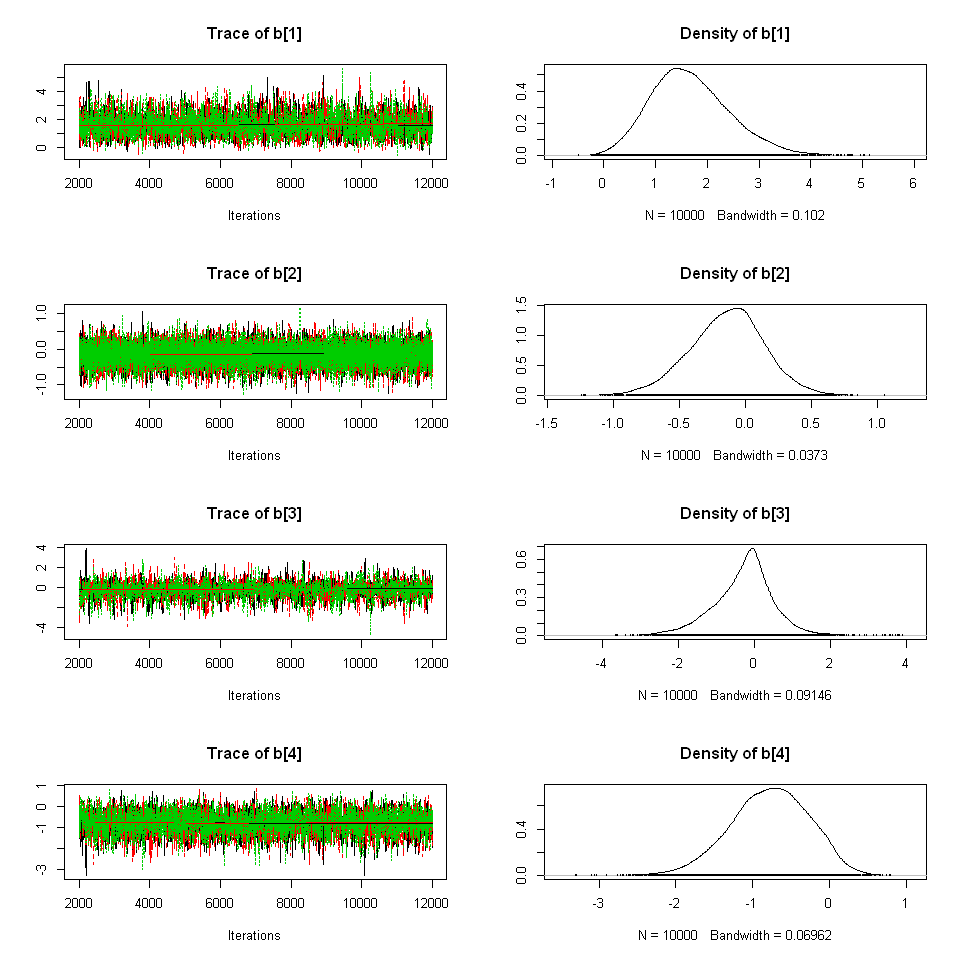

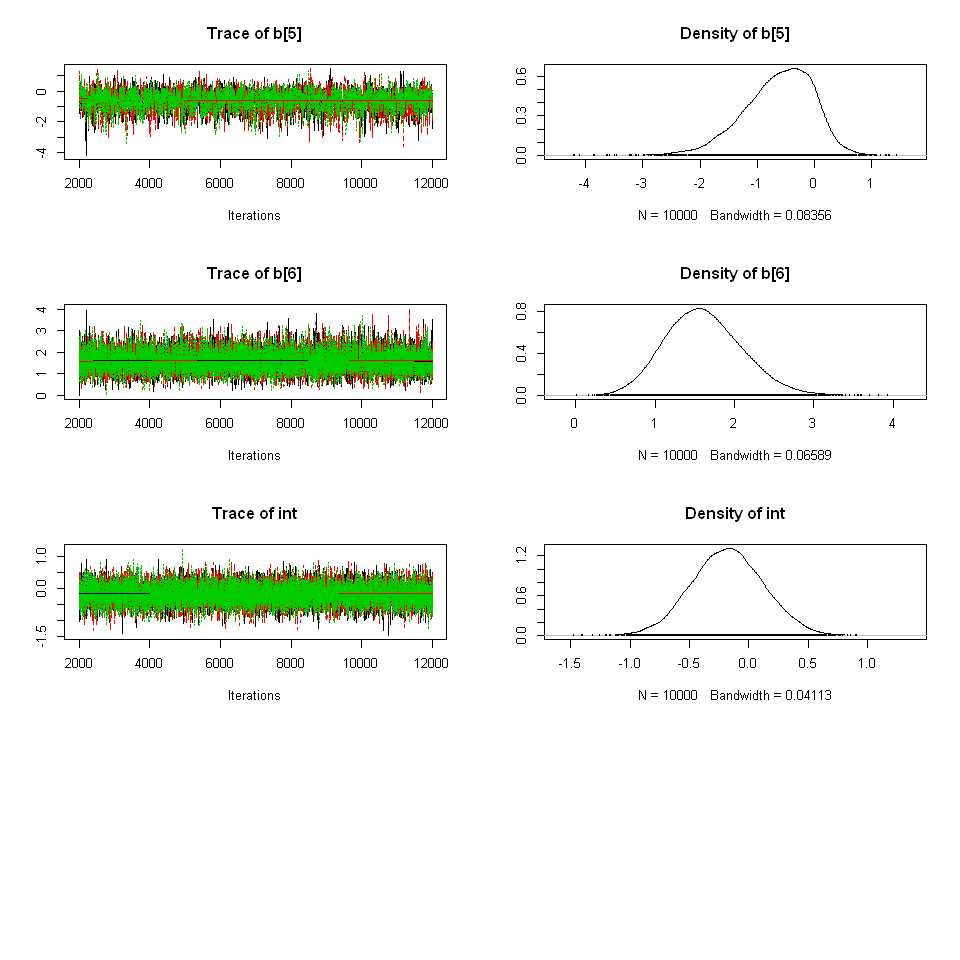

In [19]:
options(repr.plot.width=8, repr.plot.height=8)

plot(mod_1_sim)

In [20]:
gelman.diag(mod_1_sim)
autocorr.diag(mod_1_sim)
effectiveSize(mod_1_sim)

Potential scale reduction factors:

     Point est. Upper C.I.
b[1]          1       1.01
b[2]          1       1.00
b[3]          1       1.01
b[4]          1       1.01
b[5]          1       1.01
b[6]          1       1.00
int           1       1.00

Multivariate psrf

1

,b[1],b[2],b[3],b[4],b[5],b[6],int
Lag 0,1.00000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000e+00,1.000000000
Lag 1,0.84399122,0.286660831,0.895514122,0.762656448,0.813011030,4.836274e-01,0.273275366
Lag 5,0.44232674,0.003230896,0.571768042,0.346528096,0.415974610,5.017663e-02,0.025564654
Lag 10,0.20286791,0.002226681,0.317927519,0.174352960,0.193507616,1.284080e-02,0.006295793
Lag 50,-0.01163023,-0.001344669,0.009176134,0.001542888,0.004171321,-4.244348e-05,0.006936710


b[1]      b[2]      b[3]      b[4]      b[5]      b[6]       int 
 2447.409 16390.844  1635.146  2833.092  2579.028  9585.962 14951.521

### Results

In [21]:
dic_1 = dic.samples(mod1, 1e4)
dic_1

Mean deviance:  68.62 
penalty 5.433 
Penalized deviance: 74.05 

In [22]:
summary(mod_1_sim)


Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean     SD Naive SE Time-series SE
b[1]  1.6790 0.7700 0.004445       0.015575
b[2] -0.1411 0.2876 0.001660       0.002247
b[3] -0.2793 0.7990 0.004613       0.019749
b[4] -0.7765 0.5162 0.002980       0.009766
b[5] -0.6286 0.6224 0.003594       0.012286
b[6]  1.6174 0.4900 0.002829       0.005011
int  -0.1766 0.3050 0.001761       0.002503

2. Quantiles for each variable:

        2.5%     25%     50%      75%  97.5%
b[1]  0.3599  1.1357  1.6069  2.14949 3.3657
b[2] -0.7378 -0.3240 -0.1283  0.04657 0.4111
b[3] -2.0548 -0.7250 -0.1928  0.18380 1.2421
b[4] -1.8408 -1.1122 -0.7559 -0.41042 0.1432
b[5] -2.0032 -1.0086 -0.5625 -0.17834 0.3957
b[6]  0.7310  1.2745  1.5893  1.92913 2.6535
int  -0.7754 -0.3818 -0.1777  0.02777 0.4269


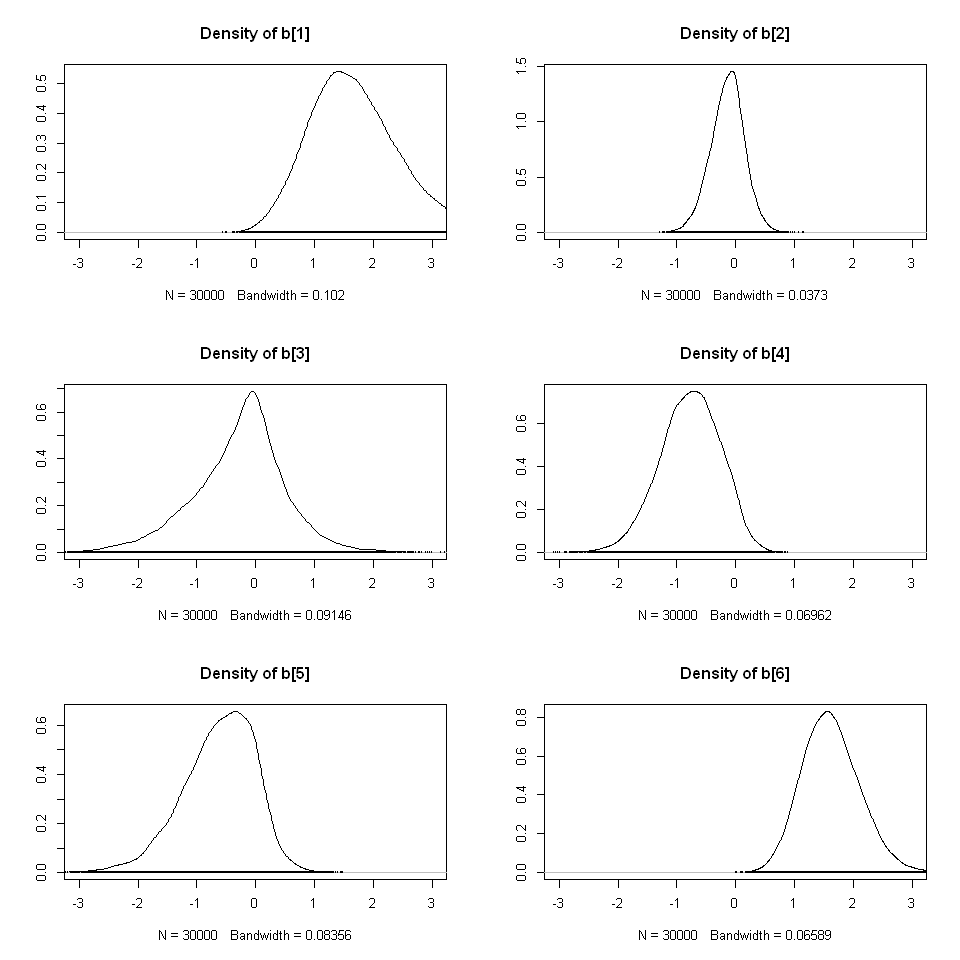

In [23]:
par(mfrow=c(3,2))
densplot(mod_1_csim[,1:6], xlim=c(-3,3))

In [24]:
colnames(X)

[1] "gravity" "ph"      "osmo"    "cond"    "urea"    "calc"

It is clear that the coefficients for variables gravity, cond (conductivity), and calc (calcium concentration) are not 0. The posterior distribution for the coefficient of osmo (osmolarity) looks like the prior, and is almost centered on 0 still, so we’ll conclude that osmo is not a strong predictor of calcium oxalate crystals. The same goes for ph.

urea (urea concentration) appears to be a borderline case. However, if we refer back to our correlations among the variables, we see that urea is highly correlated with gravity, so we opt to remove it.

<h1><center>Model 2 </center></h1>

In [25]:
mod_2_str = " model {

    # Actual Probablistic Model's Likelihood
    for(i in 1:length(y)){
        y[i] ~ dbern(p[i])
        logit(p[i]) = int + b[1]*gravity[i] + b[2]*cond[i] + b[3]*calc[i]
    }

    # Model Priors
    for(j in 1:3){
        b[j] ~ dnorm(0.0, 1.0/1.0e6) # Has variance 1
    }
    int ~ dnorm(0.0, 1.0/25) # Non informative wrt to Logistic Regression as logits' value at 2 and 3 gives high probabilitys.
} "

In [26]:
mod2 = jags.model(textConnection(mod_2_str), 
                  data = data_jags, 
                  #inits = inits, 
                  n.chains = 3)

Warning message in jags.model(textConnection(mod_2_str), data = data_jags, n.chains = 3):
"Unused variable "ph" in data"Warning message in jags.model(textConnection(mod_2_str), data = data_jags, n.chains = 3):
"Unused variable "osmo" in data"Warning message in jags.model(textConnection(mod_2_str), data = data_jags, n.chains = 3):
"Unused variable "urea" in data"

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 77
   Unobserved stochastic nodes: 4
   Total graph size: 637

Initializing model



In [27]:
update(mod2, 1e3)

In [28]:
# Monte Carlo Simulations 

mod_2_sim = coda.samples(model=mod2,
                        variable.names=params,
                        n.iter=5e3)

mod_2_csim = as.mcmc(do.call(rbind, mod_2_sim))

### Model Checking

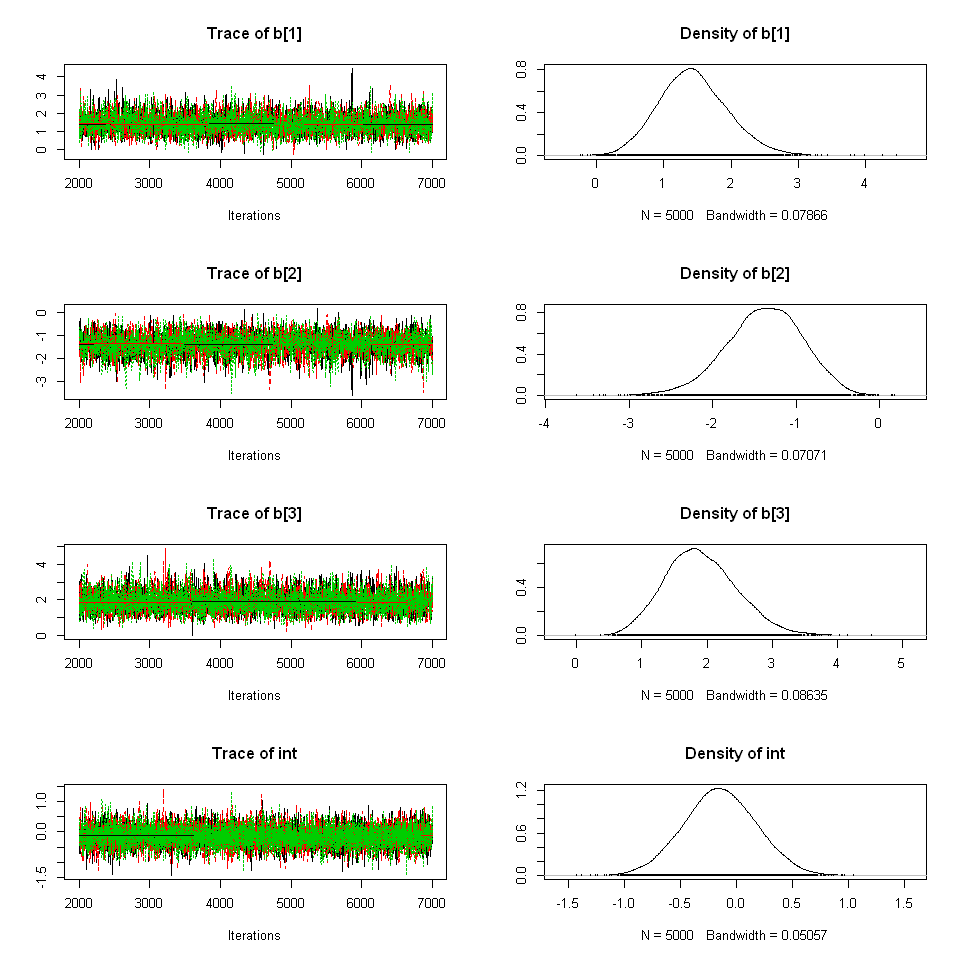

In [29]:
plot(mod_2_sim, ask=TRUE)

In [30]:
gelman.diag(mod_2_sim)
autocorr.diag(mod_2_sim)
effectiveSize(mod_2_sim)

Potential scale reduction factors:

     Point est. Upper C.I.
b[1]          1          1
b[2]          1          1
b[3]          1          1
int           1          1

Multivariate psrf

1

,b[1],b[2],b[3],int
Lag 0,1.0000000000,1.000000000,1.000000000,1.000000000
Lag 1,0.5936486223,0.677016379,0.511147402,0.287354297
Lag 5,0.1258562645,0.179318064,0.066573999,0.017448116
Lag 10,0.0002687708,0.001621422,-0.010993452,-0.007205214
Lag 50,0.0021744601,0.008334032,-0.008207272,0.005069542


b[1]     b[2]     b[3]      int 
3203.966 2677.557 4458.651 7906.385

### Results

In [31]:
summary(mod_2_sim)


Iterations = 2001:7000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean     SD Naive SE Time-series SE
b[1]  1.4403 0.5177 0.004227       0.009163
b[2] -1.3803 0.4671 0.003814       0.009039
b[3]  1.9124 0.5604 0.004576       0.008408
int  -0.1413 0.3283 0.002681       0.003692

2. Quantiles for each variable:

        2.5%     25%     50%      75%   97.5%
b[1]  0.4940  1.0859  1.4148  1.76629  2.5347
b[2] -2.3664 -1.6722 -1.3608 -1.06059 -0.5330
b[3]  0.9127  1.5197  1.8722  2.26657  3.0927
int  -0.7826 -0.3601 -0.1441  0.07728  0.5038


In [32]:
dic_2 = dic.samples(mod2, n.iter=1e3)
dic_2

Mean deviance:  71.2 
penalty 3.992 
Penalized deviance: 75.19 

In [33]:
# Compare with old model

dic_1

Mean deviance:  68.62 
penalty 5.433 
Penalized deviance: 74.05 

The DIC is actually better for the first model. Note that we did change the prior between models, and generally we should not use the DIC to choose between priors. Hence comparing DIC between these two models may not be a fair comparison. Nevertheless, they both yield essentially the same conclusions. Higher values of gravity and calc (calcium concentration) are associated with higher probabilities of calcium oxalate crystals, while higher values of cond (conductivity) are associated with lower probabilities of calcium oxalate crystals.

In [34]:
HPDinterval(mod_2_csim)

,lower,upper
b[1],0.4150362,2.4292664
b[2],-2.3113702,-0.4994955
b[3],0.8485864,3.0054429
int,-0.7652568,0.5147046


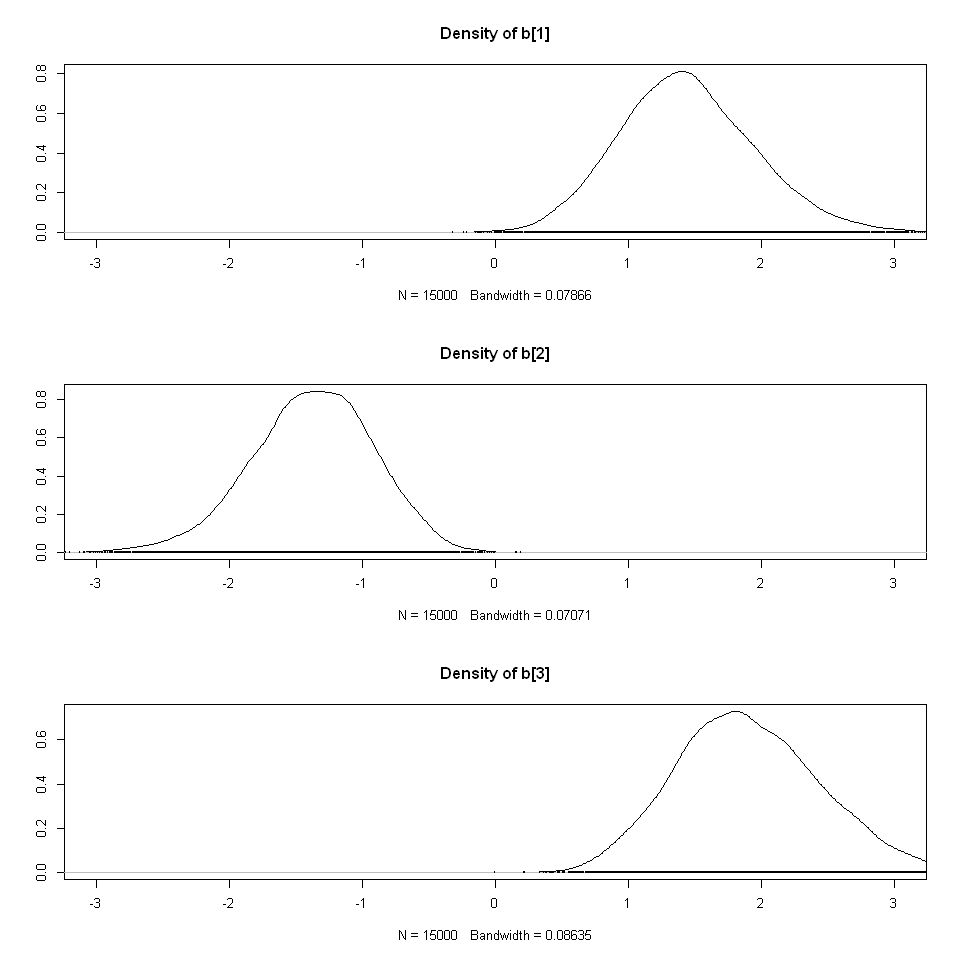

In [35]:
par(mfrow=c(3,1))
densplot(mod_2_csim[,1:3], xlim=c(-3.0, 3.0))

In [36]:
colnames(X)[c(1,4,6)] # variable names

[1] "gravity" "cond"    "calc"

<h1><center>Prediction using Model2 </center></h1>

In [37]:
pm_coef = colMeans(mod_2_csim)
pm_coef

b[1]       b[2]       b[3]        int 
 1.4403391 -1.3803329  1.9123589 -0.1412811

To make the precition we have to put the value of dependent varaible in the Sigmoid function (inverse of logit function which we are using as link function here) and it will gives us the probability.

In [38]:
sigmoid = function(y){
    1.0 / (1.0 + exp(-y))
}

In [39]:
# First we take the X matrix and matrix multiply it with the posterior means of the coefficients. 
# Then we need to pass these linear values through the inverse of the link function.

pm_Xb = pm_coef["int"] + X[,c(1,4,6)] %*% pm_coef[1:3]

# 1st term represent the intercept.
# 2nd term represent product of the Design matrix (created above and used here with permutated columns so that it 
# can be multiplied correctly with appropirate parameters) and the parameters of the model.

yhat = sigmoid(pm_Xb)

head(yhat)

# These yhat values are the model’s predicted probability of calcium oxalate crystals for each data point. 
# We can get a rough idea of how successful the model is by plotting these predicted values against the actual outcome.

2,0.50098157
3,0.10671109
4,0.22113783
5,0.10568455
6,0.27165976
7,0.08908286


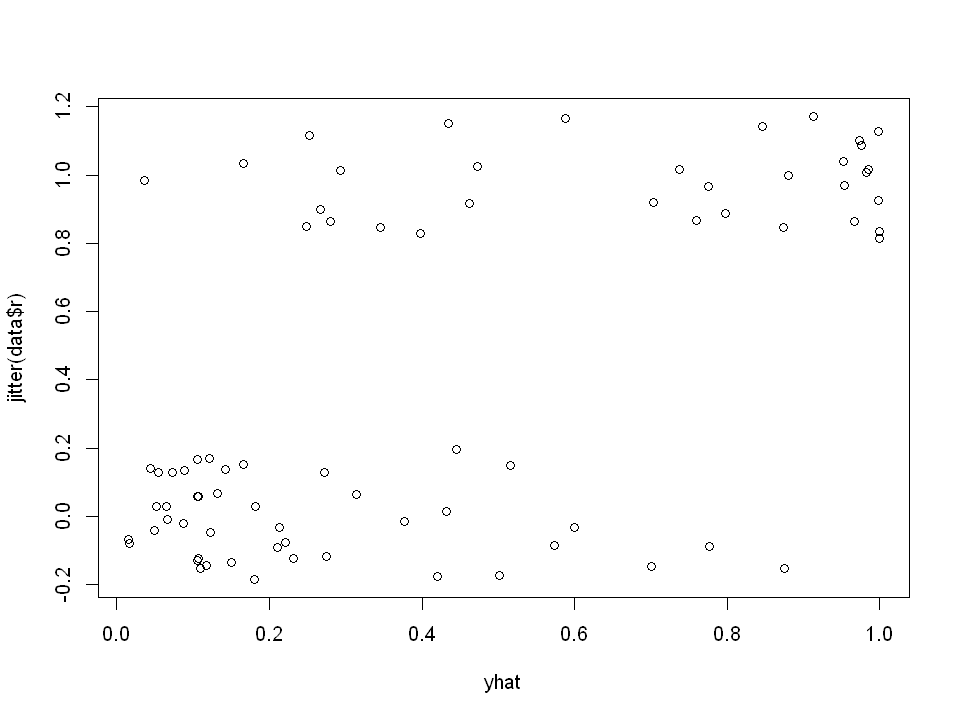

In [40]:
options(repr.plot.width=8, repr.plot.height=6)

plot(yhat, jitter(data$r))

Suppose we choose a cutoff for these predicted probabilities. If the model tells us the probability is higher than 0.5, we will classify the observation as a 1 and if it is less than 0.5, we will classify it as a 0. That way the model classifies each data point. Now we can tabulate these classifications against the truth to see how well the model predicts the original data.

In [41]:
# Lets make a confusion matrix with threshold 0.5

tab = table(yhat>0.5, data_jags$y)
tab

       
         0  1
  FALSE 37 12
  TRUE   7 21

In [42]:
# Accuracy

sum(diag(tab))/sum(tab)

[1] 0.7532468

The correct classification rate is about 76%, not too bad, but not great. Now suppose that it is considered really bad to predict no calcium oxalate crystal when there in fact is one. We might then choose to lower our threshold for classifying data points as 1s. Say we change it to 0.3. That is, if the model says the probability is greater than 0.3, we will classify it as having a calcium oxalate crystal.

In [43]:
# Lets make a confusion matrix with threshold 0.25

tab = table(yhat>0.25, data_jags$y)
tab

       
         0  1
  FALSE 30  3
  TRUE  14 30

In [44]:
# Accuracy

sum(diag(tab))/sum(tab)

[1] 0.7792208

It looks like we've not only gained little classification accuracy but also increase our chances of detecting a true positive.

We could repeat this exercise for many thresholds between 0 and 1, and each time calculate our error rates. This is equivalent to calculating what is called the ROC (receiver-operating characteristic) curve, which is often used to evaluate classification techniques.

These classification tables we have calculated were all in-sample. They were predicting for the same data used to fit the model. We could get a less biased assessment of how well our model performs if we calculated these tables for data that were not used to fit the model. For example, before fitting the model, you could withhold a set of randomly selected “test” data points, and use the model fit to the rest of the “training” data to make predictions on your “test” set.

# Another Example [Test]

In [1]:
library("car")
data("Anscombe")

In [2]:
head(Anscombe)

,education,income,young,urban
ME,189,2824,350.7,508
NH,169,3259,345.9,564
VT,230,3072,348.5,322
MA,168,3835,335.3,846
RI,180,3549,327.1,871
CT,193,4256,341.0,774


In [4]:
Xc = scale(Anscombe, center=TRUE, scale=TRUE)
head(Xc)

,education,income,young,urban
ME,-0.15743851,-0.71656340,-0.3416646,-1.0341273
NH,-0.58796740,0.06018628,-0.5419987,-0.6641113
VT,0.72514572,-0.27372680,-0.4334844,-2.2631088
MA,-0.60949384,1.08871001,-0.9844031,1.1991834
RI,-0.35117651,0.57801941,-1.3266405,1.3643691
CT,-0.07133273,1.84046085,-0.7465064,0.7234486


In [6]:
library("rjags")

In [48]:
#Model with Laplacian Priors

model_str_lp = " model {
    # Likelihood
    for(i in 1:length(education))
    {
        education[i] ~ dnorm(mu[i], prec)
        mu[i] = b[1] + b[2]*income[i] + b[3]*young[i] + b[4]*urban[i]
    }

    # Priors
    for(j in 1:4)
    {
        b[j] ~ ddexp(0.0, 2*sqrt(2))
    }
    prec ~ dgamma(1.0/2, 1.0*1.0/2.0)
    
    # Variables
    sig = 1/sqrt(prec)
} "

In [49]:
#Model with Normal Priors

model_str_np = " model {
    # Likelihood
    for(i in 1:length(education))
    {
        education[i] ~ dnorm(mu[i], prec)
        mu[i] = b[1] + b[2]*income[i] + b[3]*young[i] + b[4]*urban[i]
    }

    # Priors
    for(j in 1:4)
    {
        b[j] ~ dnorm(0.0, 1.0/1.0e6)
    }
    prec ~ dgamma(1.0/2, 1.0*1500.0/2.0)
    
    # Variables
    sig = 1/sqrt(prec)
} "

In [50]:
#Data to be fed in Model and the parameters to be estimated respectively

data_jags = as.list(Anscombe)
params_jags = c("b", "sig")

In [46]:
lp_model = jags.model(textConnection(model_str_lp), data = data_jags, n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 51
   Unobserved stochastic nodes: 5
   Total graph size: 420

Initializing model



In [47]:
np_model = jags.model(textConnection(model_str_np), data = data_jags, n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 51
   Unobserved stochastic nodes: 5
   Total graph size: 422

Initializing model



In [51]:
# Laplacian priors Model's Simulations

update(lp_model, 5e3)
lp_model_sim = coda.samples(lp_model, variable.names = params_jags, n.iter = 5e4)
lp_model_csim = as.mcmc(do.call(rbind, lp_model_sim))

In [52]:
# Normal priors Model's Simulations

update(np_model, 5e3)
np_model_sim = coda.samples(np_model, variable.names = params_jags, n.iter = 5e4)
np_model_csim = as.mcmc(do.call(rbind, np_model_sim))

#### Analysis of Model with Lapalcian Priors

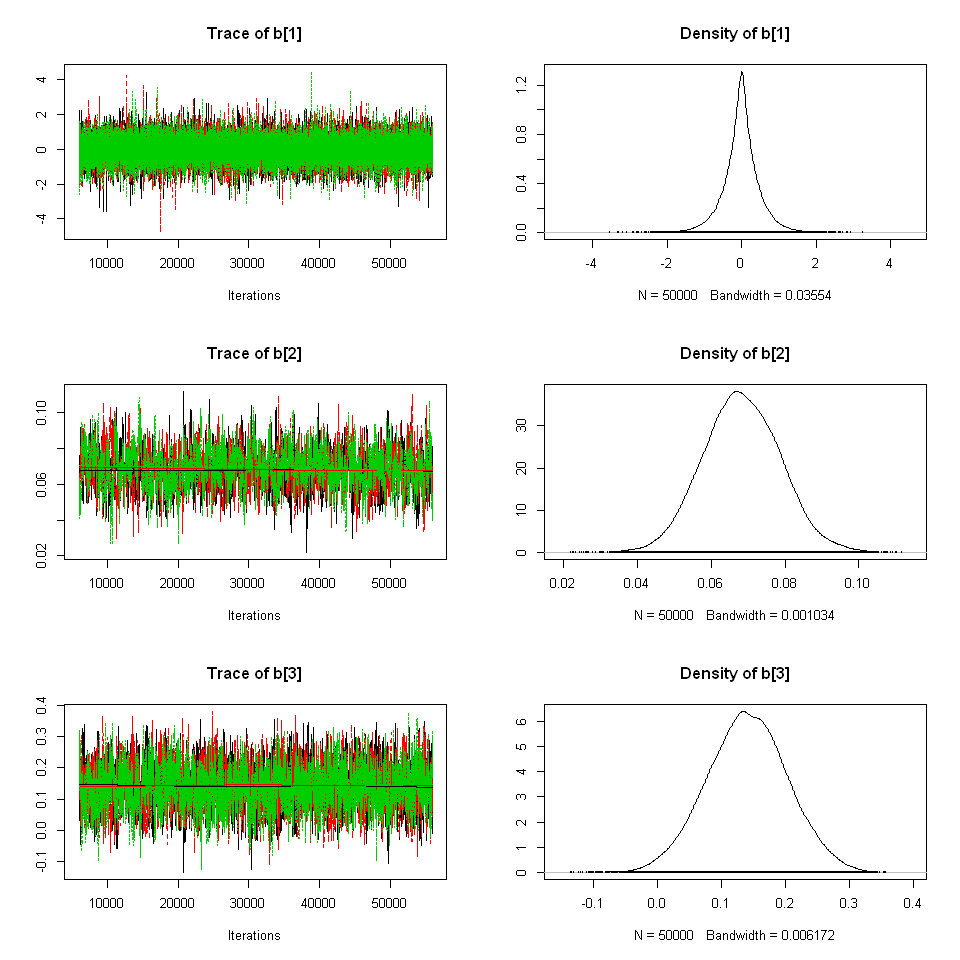

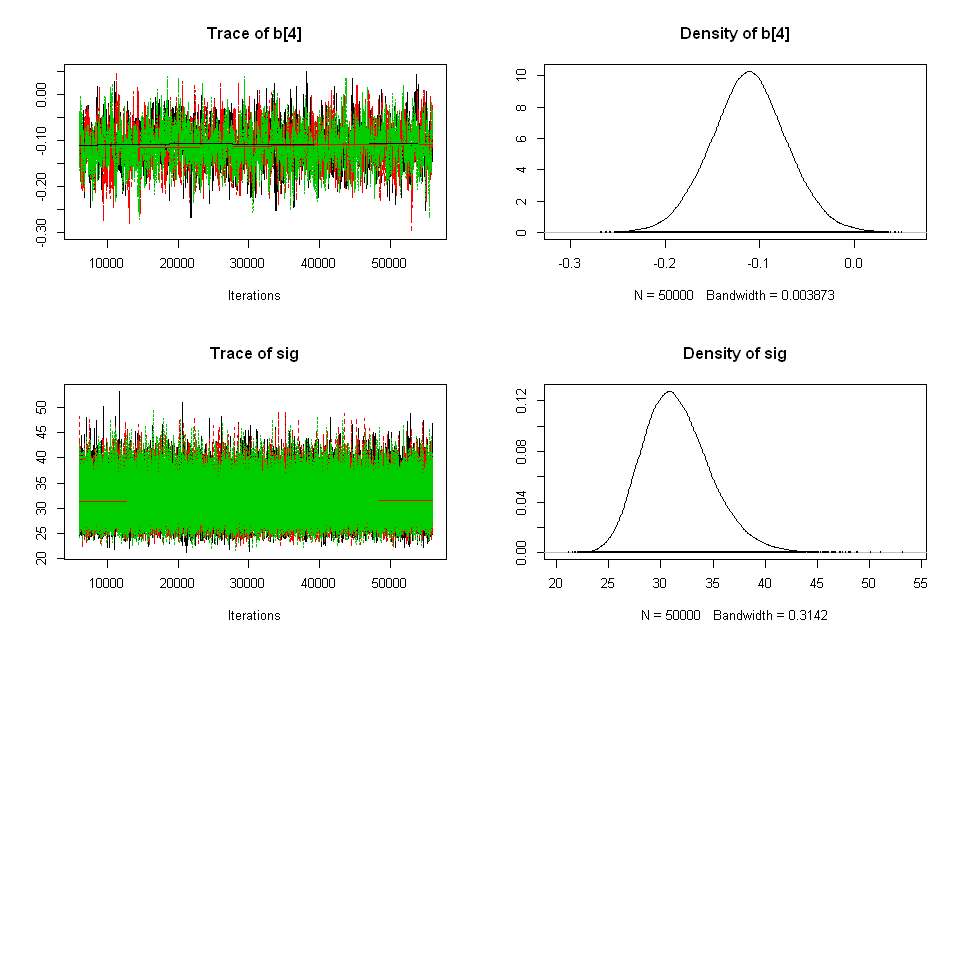

In [53]:
options(repr.plot.width=8, repr.plot.height=8)

plot(lp_model_sim)

In [54]:
gelman.diag(lp_model_sim)
autocorr.diag(lp_model_sim)
effectiveSize(lp_model_sim)

Potential scale reduction factors:

     Point est. Upper C.I.
b[1]          1       1.00
b[2]          1       1.01
b[3]          1       1.01
b[4]          1       1.01
sig           1       1.00

Multivariate psrf

1

,b[1],b[2],b[3],b[4],sig
Lag 0,1.0000000000,1.0000000,1.0000000,1.0000000,1.000000000
Lag 1,0.3620716259,0.9874547,0.9711469,0.9806146,0.061722495
Lag 5,0.0170754930,0.9403540,0.8681267,0.9112396,0.038642429
Lag 10,0.0003348788,0.8836398,0.7554482,0.8323382,0.029170288
Lag 50,-0.0027918027,0.5355693,0.2774520,0.4218983,0.009424888


b[1]       b[2]       b[3]       b[4]        sig 
65154.9814   923.2577  2107.6476  1374.0340 48821.7777

#### Anlaysis of Model with Normal Priors

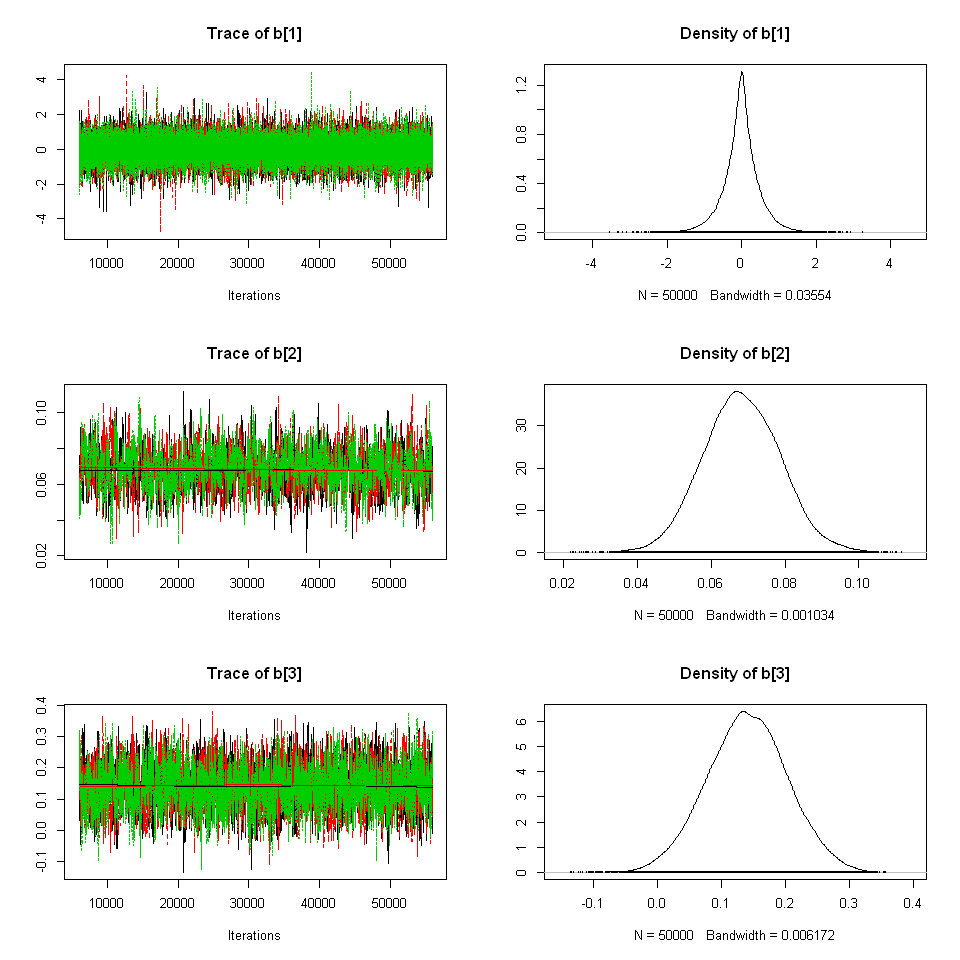

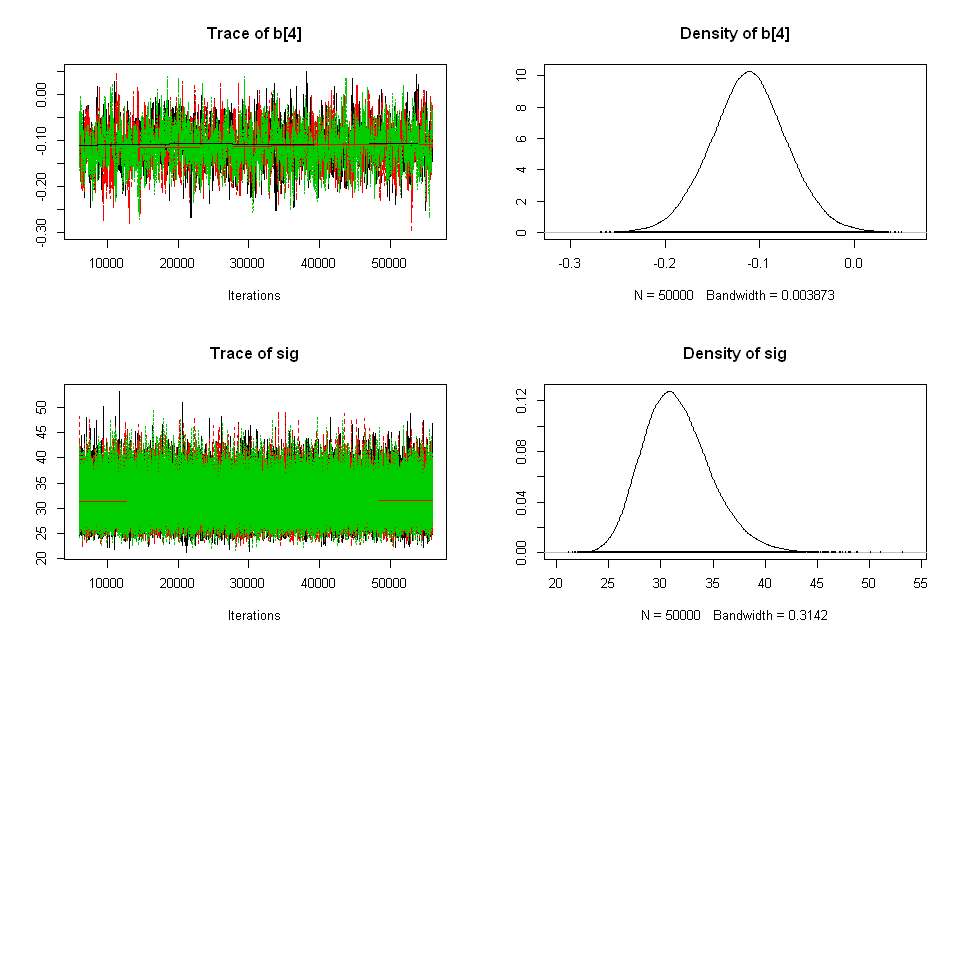

In [57]:
plot(lp_model_sim)

In [58]:
gelman.diag(np_model_sim)
autocorr.diag(np_model_sim)
effectiveSize(np_model_sim)

Potential scale reduction factors:

     Point est. Upper C.I.
b[1]       1.01       1.04
b[2]       1.01       1.02
b[3]       1.01       1.03
b[4]       1.00       1.00
sig        1.00       1.00

Multivariate psrf

1.01

,b[1],b[2],b[3],b[4],sig
Lag 0,1.0000000,1.0000000,1.0000000,1.0000000,1.00000000
Lag 1,0.9969189,0.9851806,0.9960588,0.9747659,0.07863667
Lag 5,0.9854194,0.9300803,0.9814111,0.8864759,0.04881536
Lag 10,0.9719386,0.8700430,0.9650223,0.7968617,0.04266673
Lag 50,0.8744422,0.5403104,0.8604830,0.4261468,0.02574429


b[1]       b[2]       b[3]       b[4]        sig 
  202.0231   969.0855   230.2075  1253.6422 27551.0124

### Final Parameters Estimation

In [66]:
colnames(as.data.frame(data_jags))

[1] "education" "income"    "young"     "urban"

In [67]:
# Here
# b[1] -------------> Intercept
# b[2] -------------> Coefficient of Income
# b[3] -------------> Coefficient of Young
# b[4] -------------> Coefficient of Urban

In [68]:
colMeans(lp_model_csim)

b[1]         b[2]         b[3]         b[4]          sig 
-0.009862617  0.068288773  0.141397083 -0.111134490 31.578076031

In [69]:
colMeans(np_model_csim)

b[1]          b[2]          b[3]          b[4]           sig 
-289.80582931    0.08056832    0.82504166   -0.10509121   27.45753361

In [73]:
dic.samples(lp_model, n.iter = 1e4)

Mean deviance:  497.5 
penalty 4.043 
Penalized deviance: 501.5 

In [74]:
dic.samples(np_model, n.iter = 1e4)

Mean deviance:  481 
penalty 5.184 
Penalized deviance: 486.2 